# PatchTST (Patch Time Series Transformer) — Model Walkthrough + Exercises

This notebook is built **from your `patchtst.py` implementation**. We'll go from tensor basics → patching → tokens → Transformer encoder → pooling → classifier head.

You will repeatedly answer one question: **"What is the shape here, and why?"**

---

## Notation (used everywhere)

- **B** = batch size  
- **L** = sequence length (timesteps), e.g. `1000`  
- **C** = number of channels (features), e.g. `6` (`FX, FY, FZ, MuX, MuY, MuZ`)  
- **P** = patch length (timesteps per patch), e.g. `25`  
- **S** = stride (step between patches), e.g. `25`  
- **N** = number of patches  
- **D** = model dimension (`d_model`), e.g. `128`

---

## Learning goals

By the end you can explain:

1. How `Patchify` converts `[B, L, C] → [B, N, P, C]` (and what can go wrong)
2. How patch vectors become **tokens** (Linear projection)  
3. What the Transformer encoder consumes/returns  
4. The difference between **channel-independent** vs **channel-mixed** tokenization  
5. Why the model output is a **logit** (and what sigmoid does)



In [10]:
# === Setup: imports and project path ===
import os, sys
from pathlib import Path

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Adjust these paths if needed.
# Expected project layout:
#   project_root/
#     src/patchtst.py
#     notebooks/ (optional)
SRC_DIR = "/home/tilo/Documents/Master_Thesis_Code/src/ai"
print(SRC_DIR)
if Path(SRC_DIR).exists():
    sys.path.insert(0, str(SRC_DIR))
else:
    # If you run the notebook from inside /notebooks, you might need:
    # sys.path.insert(0, str(PROJECT_ROOT.parent / "src"))
    print("WARNING: src/ not found. Update SRC_DIR accordingly.")

from patchtst import Patchify, LearnedPositionalEmbedding, TransformerEncoder, PatchTSTClassifier, PatchTSTConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


/home/tilo/Documents/Master_Thesis_Code/src/ai
device: cuda


## 1) Tensors & shapes (warmup)

### Exercise 1.1
Create a dummy batch `x` with shape `[B, L, C]` and verify it.

- Pick `B=4`, `L=1000`, `C=6`
- Print: shape, dtype, device


In [12]:
# TODO: Exercise 1.1
B, L, C = 4, 1000, 6
x = torch.randn(B, L, C, device=device)

print("x =", x)
print("type =", type(x))
print("x.shape =", tuple(x.shape))
print("x.dtype =", x.dtype)
print("x.device =", x.device)


x = tensor([[[-0.2398,  0.3022, -0.2455, -1.4628,  0.6664,  1.7679],
         [ 1.3562, -2.5183,  0.3085,  0.6800, -2.0886, -0.1571],
         [ 0.0850, -0.7326, -0.3305,  0.4032, -0.7077,  1.2302],
         ...,
         [ 1.2019, -0.9306,  0.0521,  0.2267, -1.1264,  0.0361],
         [ 0.4906,  0.5101, -2.0771,  0.6824,  1.1681,  0.0295],
         [ 0.8605, -0.4168, -0.1374,  1.0041,  0.5379,  0.4556]],

        [[ 0.3495, -1.1057, -0.6879, -0.4021,  1.6507, -1.2779],
         [-0.6986,  1.1022,  0.8252, -0.3799, -2.0462, -0.7200],
         [ 0.3689,  0.1428,  1.1053, -1.4565, -0.6260, -2.2059],
         ...,
         [-0.0865, -0.3746, -0.7276, -0.3403,  0.0209, -0.1637],
         [-1.2092, -0.0375, -0.1379,  1.2778,  0.3058,  1.5233],
         [-1.8636,  0.6425, -1.0609,  0.1377,  1.8173, -1.0328]],

        [[ 1.1483, -0.4523, -1.9086, -0.0126,  0.3029, -0.4161],
         [-0.0672,  1.6705,  1.5432, -0.8073,  0.7251, -0.6666],
         [ 0.2878,  0.9188,  2.0848,  0.7332,  0.5232,

## 2) Patchify: `[B, L, C] → [B, N, P, C]`

`Patchify` slices the time axis into windows of length `P` with step `S`.

For `pad_end=True`, the sequence is padded so we get an integer number of patches.

### Exercise 2.1 (do on paper first)
For `L=1000`, `P=25`, `S=25`:

- What is `N`?  
Use:  
$
N = \left\lfloor \frac{L - P}{S} \right\rfloor + 1
$

Then run the cell and verify.



In [26]:
P, S = 25, 25
patchify = Patchify(patch_len=P, stride=S, pad_end=True).to(device)

patches = patchify(x)
print("patches.shape =", tuple(patches.shape))
print("(number of batches, number of patches per batch, patch length, channels)")


patches.shape = (4, 40, 25, 6)
(number of batches, number of patches per batch, patch length, channels)


### Exercise 2.2 (important): verify patch layout

Your **classifier forward() assumes** `Patchify` returns `[B, N, P, C]`.

- Check if `patches.shape[2] == P` and `patches.shape[3] == C`
- If it fails, you have a dimension-ordering bug (this is exactly the bug that caused the earlier `mat1 and mat2` error).

Run the assert below. If it fails, go to the next cell and fix it **inside the notebook** (without editing the file yet).



In [27]:
# TODO: Exercise 2.2
assert patches.shape[2] == P, f"Expected patches.shape[2]==P ({P}), got {patches.shape}"
assert patches.shape[3] == C, f"Expected patches.shape[3]==C ({C}), got {patches.shape}"
print("✅ Patch layout looks like [B, N, P, C]")


✅ Patch layout looks like [B, N, P, C]


### If the assert above fails: patchify is returning the wrong layout

A common confusion:

- `x.unfold(dimension=1, size=P, step=S)` on `[B, L, C]` returns **`[B, N, P, C]`** (the new patch dimension `P` appears before `C`).

If your implementation permutes dimensions afterward, it may accidentally swap `P` and `C`.

#### Exercise 2.3
Implement a **fixed patchify** module here that always returns `[B, N, P, C]`, and re-run the assert.



In [29]:
# TODO: Exercise 2.3 — create a fixed Patchify version (only used in this notebook)

class PatchifyFixed(nn.Module):
    def __init__(self, patch_len: int, stride: int, pad_end: bool = True):
        super().__init__()
        self.patch_len = patch_len
        self.stride = stride
        self.pad_end = pad_end

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, L, C]
        B, L, C = x.shape
        P, S = self.patch_len, self.stride

        # Minimal pad_end logic (matches your file conceptually)
        if self.pad_end:
            if L < P:
                L_pad = P
            else:
                rem = (L - P) % S
                L_pad = L if rem == 0 else L + (S - rem)
            if L_pad != L:
                x = torch.nn.functional.pad(x, (0, 0, 0, L_pad - L), value=0.0)
                L = L_pad

        patches = x.unfold(dimension=1, size=P, step=S)   # [B, N, P, C]
        # No further permute needed for [B, N, P, C]
        patches = patches.permute(0,1,3,2)
        return patches.contiguous()

patchify_fixed = PatchifyFixed(P, S, pad_end=True).to(device)
patches_fixed = patchify_fixed(x)
print("patches_fixed.shape =", tuple(patches_fixed.shape))

assert patches_fixed.shape[2] == P and patches_fixed.shape[3] == C
print("✅ Fixed patchify returns [B, N, P, C]")


patches_fixed.shape = (4, 40, 25, 6)
✅ Fixed patchify returns [B, N, P, C]


## 3) Visualizing patches (intuition)

We'll create a simple 1D signal (a ramp + noise), patch it, and plot the first few patches.

### Exercise 3.1
- Create a signal of length 1000
- Patchify it with P=25, S=25
- Plot the first 5 patches



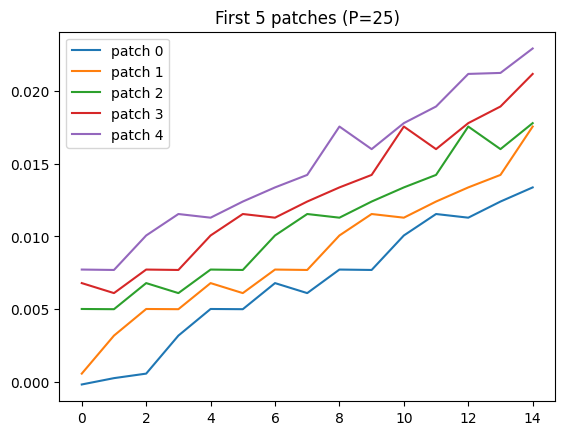

In [40]:
# TODO: Exercise 3.1

L = 1000
t = torch.linspace(0, 1, steps=L, device=device)
sig = t + 0.001 * torch.randn(L, device=device)  # 1D signal
sig = sig.view(1, L, 1)                         # [B=1, L, C=1]

P, S = 15, 2
patches = PatchifyFixed(P, S, pad_end=True).to(device)(sig)  # [1, N, P, 1]
patches = patches.squeeze(0).squeeze(-1).detach().cpu()      # [N, P]

plt.figure()
for i in range(5):
    plt.plot(patches[i].numpy(), label=f"patch {i}")
plt.title("First 5 patches (P=25)")
plt.legend()
plt.show()


## 4) From patches → tokens (Linear projection)

A patch of length `P` becomes a vector of length `D` (token embedding) using `nn.Linear(P, D)`.

### Exercise 4.1
- Create random patches `[B*C, N, P]`
- Apply a linear layer `Linear(P, D)`
- Verify output `[B*C, N, D]`



In [41]:
# TODO: Exercise 4.1
B, C = 4, 6
N, P, D = 40, 25, 128

patches_bc = torch.randn(B*C, N, P, device=device)
proj = nn.Linear(P, D).to(device)
tokens = proj(patches_bc)

print("patches_bc:", tuple(patches_bc.shape))
print("tokens    :", tuple(tokens.shape))
assert tokens.shape == (B*C, N, D)


patches_bc: (24, 40, 25)
tokens    : (24, 40, 128)


## 5) Positional embeddings

Transformers don't know patch order unless we inject it.

Your code uses a **learned positional embedding**: `nn.Embedding(max_patches, D)`.

### Exercise 5.1
- Create tokens `[B, N, D]`
- Apply `LearnedPositionalEmbedding(D)`
- Verify shape unchanged and that values change



In [46]:
# TODO: Exercise 5.1
B, N, D = 2, 40, 128
tokens = torch.zeros(B, N, D, device=device)

pos = LearnedPositionalEmbedding(d_model=D, max_patches=4096, dropout=0.0).to(device)
tokens_pe = pos(tokens)

print("tokens_pe shape:", tuple(tokens_pe.shape))
print("mean(abs(tokens_pe)):", tokens_pe.abs().mean().item())


tokens_pe shape: (2, 40, 128)
mean(abs(tokens_pe)): 0.7938722968101501


## 6) Transformer encoder (black box, but shape-stable)

Your encoder consumes `[B, N, D]` and returns `[B, N, D]`.

### Exercise 6.1
- Instantiate `TransformerEncoder`
- Pass tokens through and verify shape



In [47]:
# TODO: Exercise 6.1
enc = TransformerEncoder(d_model=128, n_heads=8, n_layers=2, d_ff=256, dropout=0.1, activation="gelu").to(device)
x_tok = torch.randn(3, 40, 128, device=device)
z = enc(x_tok)
print("z.shape =", tuple(z.shape))
assert z.shape == x_tok.shape


z.shape = (3, 40, 128)


/home/tilo/Documents/Master_Thesis_Code/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## 7) Full PatchTSTClassifier forward pass — shape tracing

Now we connect it all via `PatchTSTClassifier`.

### Exercise 7.1
Create a `PatchTSTConfig` for **binary classification** and run one forward pass.

Important:
- For `BCEWithLogitsLoss`, use `num_classes=1` so the model outputs **one logit** per sample.


In [ ]:
# TODO: Exercise 7.1
cfg = PatchTSTConfig(
    num_classes=1,
    patch_len=25,
    stride=25,
    d_model=128,
    n_heads=8,
    n_layers=4,
    d_ff=256,
    dropout=0.1,
    channel_independent=True,
    pooling="mean",
    fuse="mean",
)

model = PatchTSTClassifier(cfg).to(device)

x = torch.randn(4, 1000, 6, device=device)
logits = model(x)

print("logits.shape =", tuple(logits.shape))


### Exercise 7.2 (core understanding): trace the intermediate shapes

Re-implement the channel-independent forward pipeline manually using the model modules:

1. `patchify(x)`  
2. `permute` to `[B, C, N, P]`  
3. `view(B*C, N, P)`  
4. `patch_proj` → tokens `[B*C, N, D]`  
5. `pos_emb`  
6. `encoder`  
7. mean-pool over tokens  
8. reshape back to `[B, C, D]`  
9. fuse channels (mean) → `[B, D]`  
10. head → `[B, 1]`

Fill in the TODOs. Use `assert` for every step.



In [ ]:
# TODO: Exercise 7.2 — manual forward (channel-independent, mean pooling, mean fuse)

B, L, C = 4, 1000, 6
x = torch.randn(B, L, C, device=device)

# Step 1
patches = model.patchify(x)  # should be [B, N, P, C]
print("patches:", tuple(patches.shape))

# Step 2 (TODO)
# patches_bc_np = ...

# Step 3 (TODO)
# patches_bcnp = ...

# Step 4
# tokens = ...

# Step 5
# tokens = ...

# Step 6
# z = ...

# Step 7
# rep = ...

# Step 8
# rep = ...

# Step 9
# rep_fused = ...

# Step 10
# logits_manual = ...

# Compare to model(x)
logits_model = model(x)
# print("max abs diff:", (logits_manual - logits_model).abs().max().item())


## 8) Channel-mixed mode (optional advanced)

In channel-mixed mode each patch token contains **all channels**: patch vector length = `P*C`.

### Exercise 8.1
- Set `channel_independent=False`
- Run forward and verify it still works
- Compare parameter counts (channel-mixed uses LazyLinear for patch projection)



In [ ]:
# TODO: Exercise 8.1
cfg_mixed = PatchTSTConfig(
    num_classes=1,
    patch_len=25,
    stride=25,
    d_model=128,
    n_heads=8,
    n_layers=2,
    d_ff=256,
    dropout=0.1,
    channel_independent=False,  # key change
    pooling="mean",
)

model_mixed = PatchTSTClassifier(cfg_mixed).to(device)

x = torch.randn(4, 1000, 6, device=device)
logits = model_mixed(x)
print("logits.shape =", tuple(logits.shape))

# Parameter counts
def n_params(m): return sum(p.numel() for p in m.parameters())
print("params (CI):   ", n_params(model))
print("params (mixed):", n_params(model_mixed))


## 9) Mini-training on synthetic data (fast sanity check)

We build a tiny dataset where the label depends on whether channel 0 has a positive mean in the first half.

### Exercise 9.1
- Train for ~10 epochs
- Watch loss go down and accuracy go up
- Try changing `patch_len` and see effects

This is *not* your real task — it's to understand the training dynamics without file I/O.



In [ ]:
# Synthetic dataset
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, n=512, L=200, C=6):
        self.x = torch.randn(n, L, C)
        # label=1 if mean of channel 0 in first half > 0
        y = (self.x[:, :L//2, 0].mean(dim=1) > 0).float()
        self.y = y

    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

toy = ToyDataset(n=800, L=200, C=6)
train_toy, val_toy = torch.utils.data.random_split(toy, [640, 160], generator=torch.Generator().manual_seed(0))

train_loader = torch.utils.data.DataLoader(train_toy, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_toy, batch_size=64, shuffle=False)

cfg_toy = PatchTSTConfig(
    num_classes=1,
    patch_len=10,
    stride=10,
    d_model=64,
    n_heads=4,
    n_layers=2,
    d_ff=128,
    dropout=0.1,
    channel_independent=True,
    pooling="mean",
    fuse="mean",
)
toy_model = PatchTSTClassifier(cfg_toy).to(device)

opt = torch.optim.AdamW(toy_model.parameters(), lr=1e-3, weight_decay=1e-2)
crit = nn.BCEWithLogitsLoss()

def acc_from_logits(logits, y):
    p = (torch.sigmoid(logits) >= 0.5).float()
    return (p == y).float().mean().item()

for epoch in range(1, 11):
    toy_model.train()
    tr_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad()
        logits = toy_model(xb).squeeze(-1)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()
        tr_loss += loss.item() * xb.size(0)
    tr_loss /= len(train_loader.dataset)

    toy_model.eval()
    va_loss = 0.0
    va_acc = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = toy_model(xb).squeeze(-1)
            loss = crit(logits, yb)
            va_loss += loss.item() * xb.size(0)
            va_acc  += acc_from_logits(logits, yb) * xb.size(0)
            n += xb.size(0)
    va_loss /= n
    va_acc  /= n
    print(f"epoch {epoch:02d} | train loss {tr_loss:.3f} | val loss {va_loss:.3f} | val acc {va_acc:.3f}")


## What to do next

1. Complete **Exercise 7.2** (manual forward).  
   If you can do that, you understand 80% of `patchtst.py`.

2. If your Patchify assert failed, fix the actual source file after you prove the fix works here.

3. Move on to the training notebook:
   - Dataset → DataLoader → train loop → evaluate → threshold sweep

